In [265]:
import numpy as np
import math
from sklearn.preprocessing import OrdinalEncoder
from sklearn.datasets import load_digits
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
    
def load_occupancy_training():
    enc = OrdinalEncoder()
    
    f = open('./datatraining.txt')
    lines = f.readlines()[1:] #eliminate categories
    lines = [line.strip().split(',') for line in lines]
    f.close()
    
    X, y = [ls[:-1] for ls in lines],[ls[-1] for ls in lines]
    enc.fit(X)
    X = enc.transform(X)
    y = [int(i) for i in y]
    
    return np.array(X), np.array(y)

def load_occupancy_test():
    enc = OrdinalEncoder()
    
    f = open('./datatest.txt')
    lines = f.readlines()[1:] #eliminate categories
    lines = [line.strip().split(',') for line in lines]
    f.close()
    
    X, y = [ls[:-1] for ls in lines],[ls[-1] for ls in lines]
    enc.fit(X)
    X = enc.transform(X)
    y = [int(i) for i in y]
    
    return np.array(X), np.array(y)

def get_best_model(scores):
    best = 0
    best_index = 0
    s = scores['test_score']
    for i in range(len(s)):
        if s[i] > best:
            best = s[i]
            best_index = i

    best_model = scores['estimator'][best_index]
    return best_model

def get_best_score(scores):
    best = 0
    best_index = 0
    s = scores['test_score']
    for i in range(len(s)):
        if s[i] > best:
            best = s[i]
            best_index = i
        
    return best, best_index

occupancyTrainX, occupancyTrainY = load_occupancy_training()
occTestX, occTestY = load_occupancy_test()


digitData, digitTarget = load_digits(return_X_y=True)

trainDigitX, \
testDigitX, \
trainDigitY, \
testDigitY = train_test_split(digitData, digitTarget, test_size=.35)

trainDigitX, \
validDigitX, \
trainDigitY, \
validDigitY = train_test_split(trainDigitX, trainDigitY, test_size=.35)

occTrainX, occValidX, occTrainY, occValidY = train_test_split(occupancyTrainX, occupancyTrainY, test_size=.35)




In [266]:
# Learning Curve plotting function

def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : object type that implements the "fit" and "predict" methods
        An object of that type which is cloned for each validation.

    title : string
        Title for the chart.

    X : array-like, shape (n_samples, n_features)
        Training vector, where n_samples is the number of samples and
        n_features is the number of features.

    y : array-like, shape (n_samples) or (n_samples, n_features), optional
        Target relative to X for classification or regression;
        None for unsupervised learning.

    axes : array of 3 axes, optional (default=None)
        Axes to use for plotting the curves.

    ylim : tuple, shape (ymin, ymax), optional
        Defines minimum and maximum yvalues plotted.

    cv : int, cross-validation generator or an iterable, optional
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:
          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, optional (default=None)
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    train_sizes : array-like, shape (n_ticks,), dtype float or int
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the dtype is float, it is regarded as a
        fraction of the maximum size of the training set (that is determined
        by the selected validation method), i.e. it has to be within (0, 1].
        Otherwise it is interpreted as absolute sizes of the training sets.
        Note that for classification the number of samples usually have to
        be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")
    
     # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")



In [267]:
# Validation Curve plotting function

def plot_validation_curve(estimator, title, X, y, param, param_range, axes=None, ylim=(0.0,1.1), cv=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Tuned Parameter: " + param)
    axes[0].set_ylabel("Score")
        
    train_scores, test_scores = \
        validation_curve(estimator, X, y, param_name=param, param_range=param_range,
        scoring="accuracy", n_jobs=n_jobs)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    lw = 2
    
    
    axes[0].plot(param_range, train_scores_mean, label="Training score",
             color="darkorange")

    axes[0].plot(param_range, test_scores_mean, label="Cross-validation score",
                 color="navy")

    axes[0].legend(loc="best")






DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='entropy',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=0.05, min_samples_split=0.05,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=0, splitter='best')
0.6479217603911981
0.6581875993640699
DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_

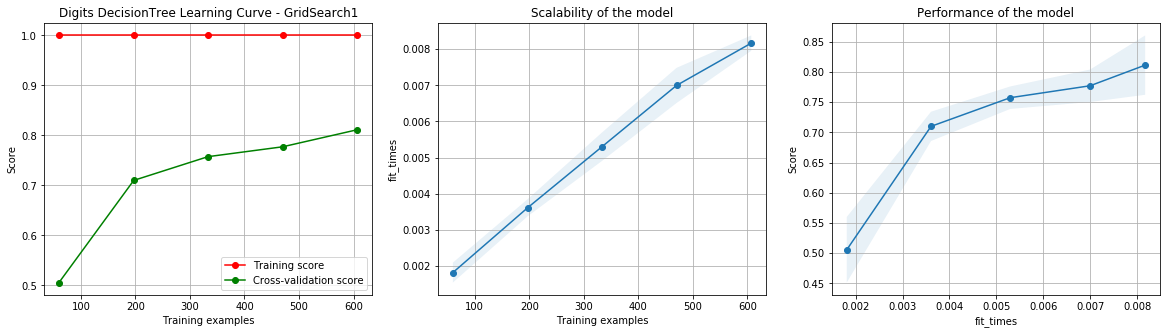

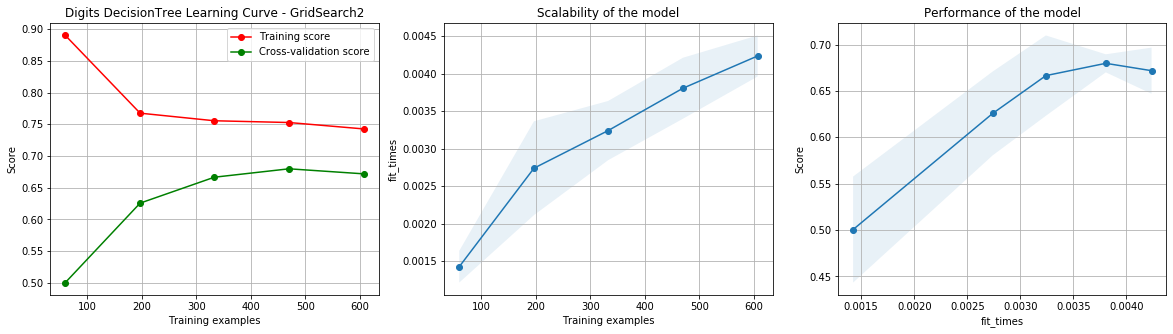

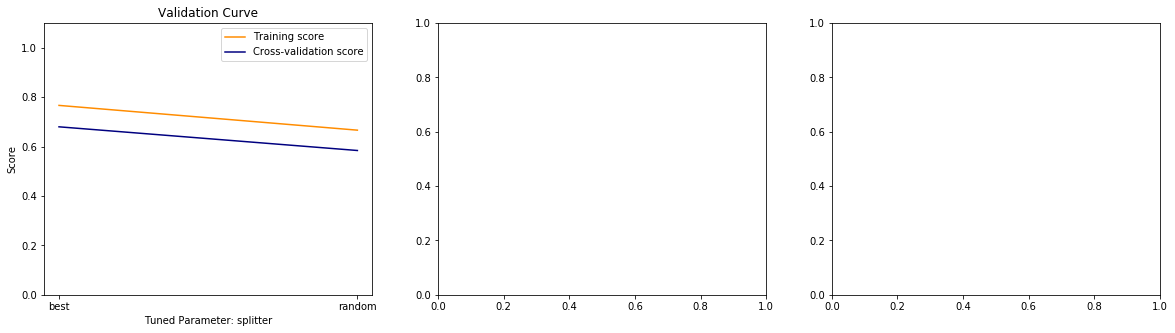

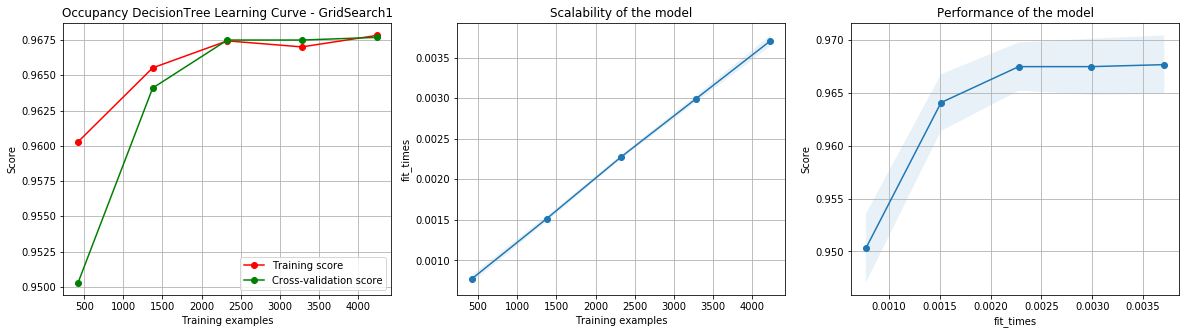

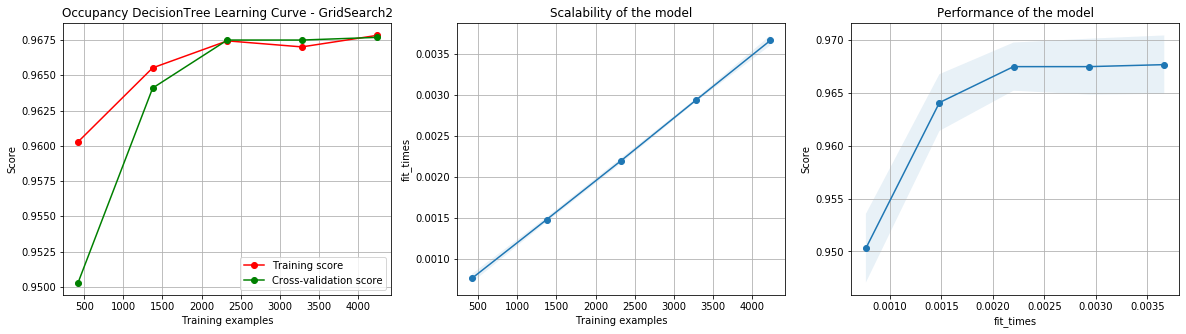

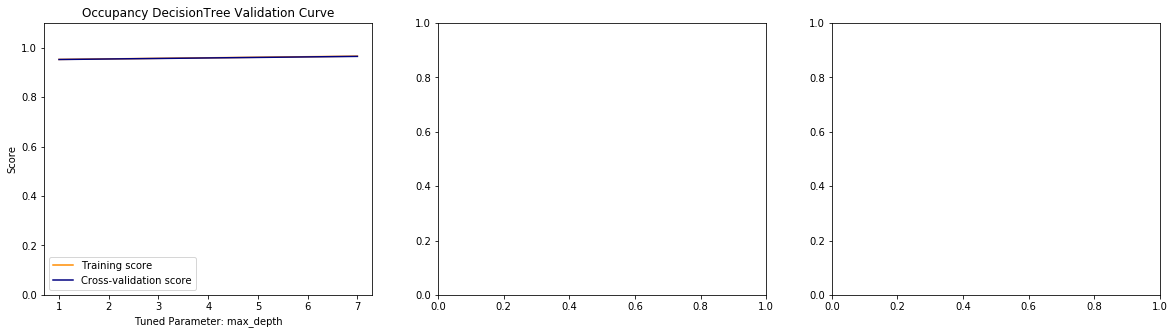

In [268]:
# For DecisionTreeClassifier, training without setting any parameters will lead to a perfect-fitting tree because of the
# max_depth parameter.  For this, I begin with a GridSearch to see what parameters get the best fit

# Create Classifier
t = DecisionTreeClassifier()

# Get pruning alphas for Digit Dataset
path = t.cost_complexity_pruning_path(trainDigitX, trainDigitY)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Create Parameter dictionary for GridSearch
params = {
    'criterion': ['entropy'],
    'random_state': [0],
    'ccp_alpha': ccp_alphas  
}

# Perform Grid Search
clf = GridSearchCV(t, param_grid=params)
clf.fit(trainDigitX, trainDigitY)
best_tree = clf.best_estimator_
print(best_tree)

plot_learning_curve(best_tree, "Digits DecisionTree Learning Curve - GridSearch1", trainDigitX, trainDigitY, n_jobs=3)

params = {
    'min_samples_split': [.05, .1, .2, .3],
    'min_samples_leaf': [.05, .1, .2, .3]
}

clf = GridSearchCV(best_tree, param_grid=params)
clf.fit(trainDigitX, trainDigitY)
best_tree = clf.best_estimator_
print(best_tree)

plot_learning_curve(clf.best_estimator_, "Digits DecisionTree Learning Curve - GridSearch2", trainDigitX, trainDigitY, n_jobs=3)

# Test validation curve with unused parameter

plot_validation_curve(best_tree, "Validation Curve", validDigitX, validDigitY, \
                      "splitter", ['best', 'random'])

best_tree.set_params(splitter='best')

ypred = best_tree.predict(validDigitX)
print(accuracy_score(ypred, validDigitY))

ypred = best_tree.predict(testDigitX)
print(accuracy_score(ypred, testDigitY))

# #################
# # Occupancy Data
# #################

# # Reinitialize Classifier
t = DecisionTreeClassifier()

# Pruning alphas for Occupancy Dataset

path = t.cost_complexity_pruning_path(occTrainX, occTrainY)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

# Create Parameter Dictionary for GridSearch
params = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'random_state': [0],
    'ccp_alpha': ccp_alphas,    
    'min_samples_leaf': [.05, .1, .2, .3]
}

# Perform Grid Search
clf = GridSearchCV(t, param_grid=params, n_jobs=3)
clf.fit(occTrainX, occTrainY)

occTree = clf.best_estimator_
print(occTree)
plot_learning_curve(occTree, "Occupancy DecisionTree Learning Curve - GridSearch1", occTrainX, occTrainY, n_jobs=3)

params = {
    'min_samples_split': [.05, .1, .2, .3]
}

clf = GridSearchCV(occTree, param_grid=params, n_jobs=3)
clf.fit(occTrainX, occTrainY)

occTree = clf.best_estimator_
print(occTree)
plot_learning_curve(occTree, "Occupancy DecisionTree Learning Curve - GridSearch2", occTrainX, occTrainY, n_jobs=3)

# Plot validation Curve
n_features = occTrainX.shape[1]
plot_validation_curve(occTree, "Occupancy DecisionTree Validation Curve", \
                      occValidX, occValidY, "max_depth", [1, n_features], n_jobs=3)

ypred = occTree.predict(occValidX)
print(accuracy_score(ypred, occValidY))
ypred = occTree.predict(occTestX)
print(accuracy_score(ypred, occTestY))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=2, n_neighbors=5, p=1,
                     weights='distance')
0.9853300733496333
0.9809220985691574
Score against Validation Set: 0.992283
Score against Test Set: 0.740338


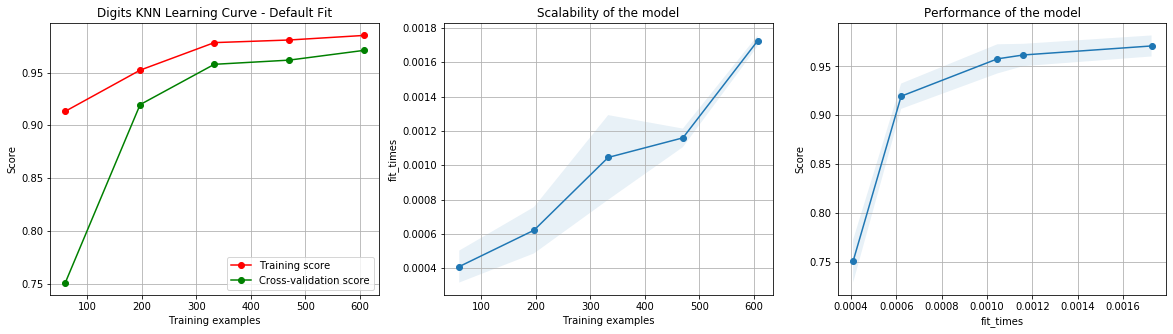

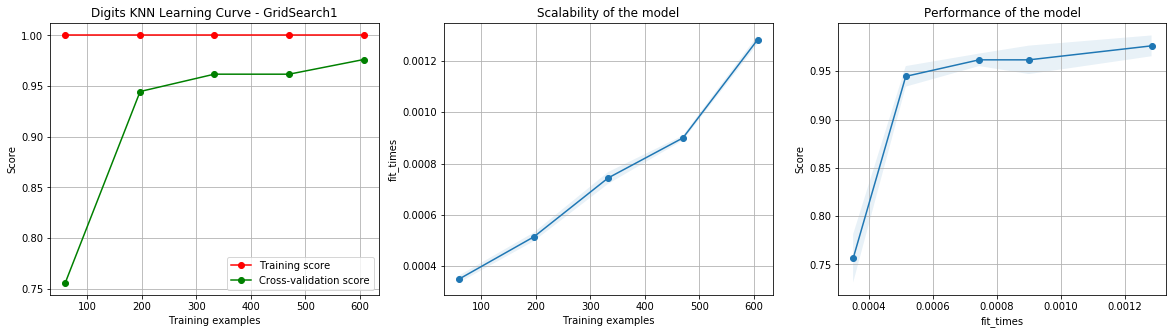

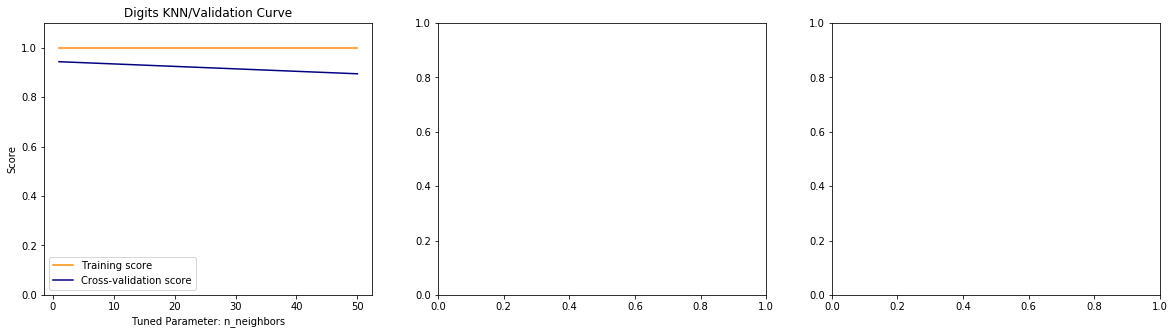

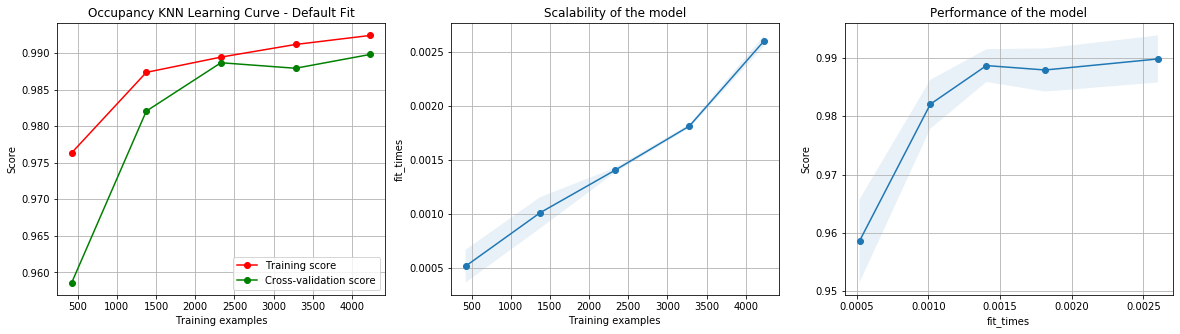

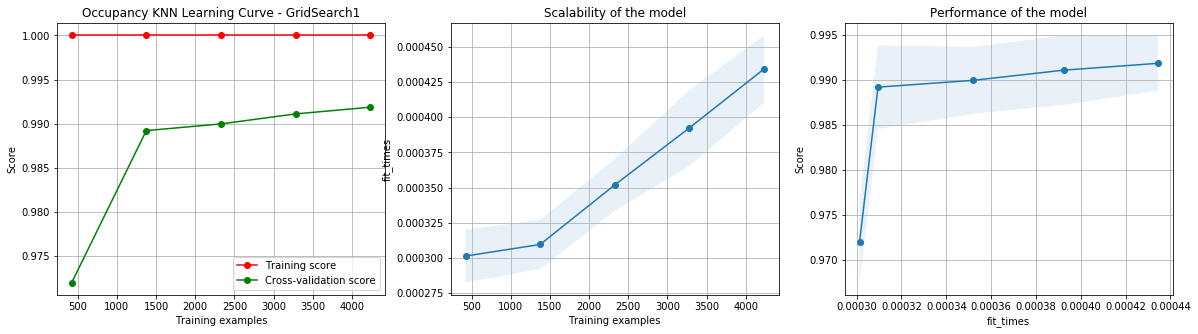

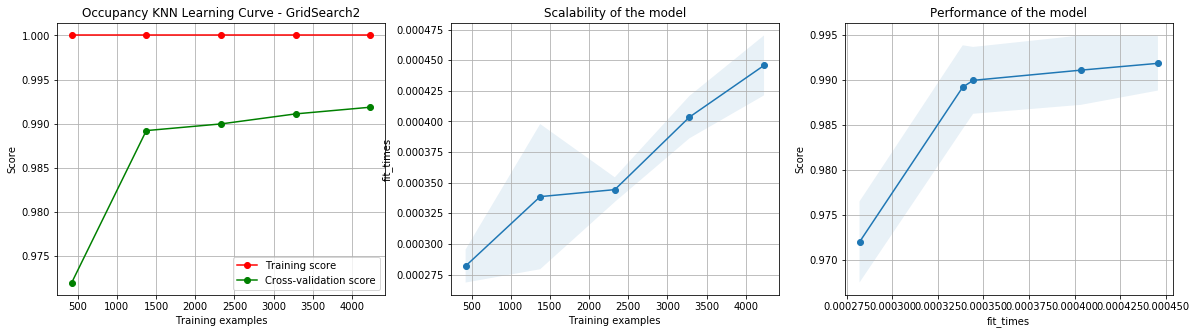

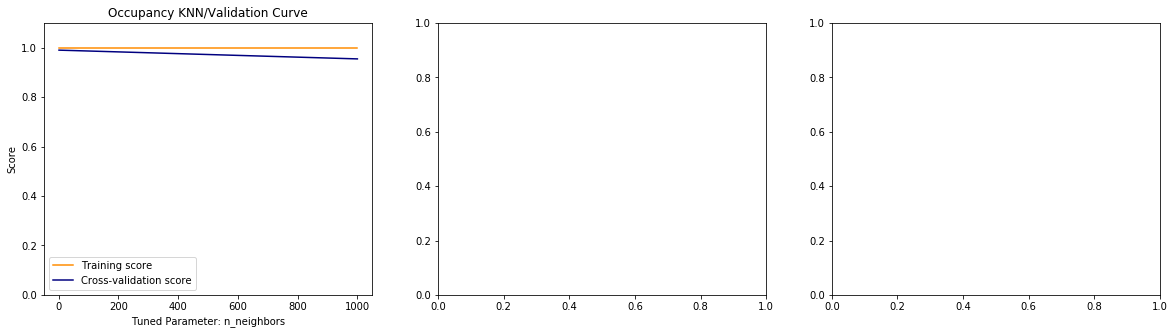

In [269]:
# K-Nearest Neighbors
# For KNN, begin by plotting learning curve with default KNNClassifier Object

knn = KNeighborsClassifier()
knn.fit(trainDigitX, trainDigitY)

plot_learning_curve(knn, "Digits KNN Learning Curve - Default Fit", trainDigitX, trainDigitY, n_jobs=3)

# Create dictionary of HyperParameters for GridSearch

trainSize = trainDigitX.shape[0]

params = {
    'algorithm': ['ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3],
    'n_jobs': [2]
}

clf = GridSearchCV(knn, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)
best_knn = clf.best_estimator_
print(best_knn)

plot_learning_curve(best_knn, "Digits KNN Learning Curve - GridSearch1", trainDigitX, trainDigitY, n_jobs=3)


# Validation Curve

plot_validation_curve(best_knn, "Digits KNN/Validation Curve", validDigitX, validDigitY, "n_neighbors", [1, 50])

best_knn.set_params(n_neighbors=2)

ypred = best_knn.predict(validDigitX)
print(accuracy_score(ypred, validDigitY))
ypred = best_knn.predict(testDigitX)
print(accuracy_score(ypred, testDigitY))

# #################
# # Occupancy Data
# #################

trainSize = occTrainX.shape[0]

knn = KNeighborsClassifier()
knn.fit(occTrainX, occTrainY)

plot_learning_curve(knn, "Occupancy KNN Learning Curve - Default Fit", occTrainX, occTrainY, n_jobs=2)

params = {
    'algorithm': ['brute','ball_tree', 'kd_tree'],
    'weights': ['uniform', 'distance'],
    'p': [1, 2, 3]
}

clf = GridSearchCV(knn, param_grid=params, n_jobs=2)
clf.fit(occTrainX, occTrainY)

best_knn = clf.best_estimator_

plot_learning_curve(best_knn, "Occupancy KNN Learning Curve - GridSearch1", occTrainX, occTrainY, n_jobs=2)

params = {
    'leaf_size': [(trainSize)//n for n in range(1,200) if n % 5 == 0]
}

clf = GridSearchCV(best_knn, param_grid=params, n_jobs=2)
clf.fit(occTrainX, occTrainY)

best_knn = clf.best_estimator_

plot_learning_curve(best_knn, "Occupancy KNN Learning Curve - GridSearch2", occTrainX, occTrainY, n_jobs=2)

# Validation curve
plot_validation_curve(best_knn, "Occupancy KNN/Validation Curve", occValidX, occValidY, "n_neighbors", [1, 1000])


ypred = best_knn.predict(occValidX)
print("Score against Validation Set: %f" % accuracy_score(ypred, occValidY))
ypred = best_knn.predict(occTestX)
print("Score against Test Set: %f" % accuracy_score(ypred, occTestY))






/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)
/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:571: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % sel

MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(2, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(activation='identity', alpha=0.0001, batch_size='auto',
              beta_1=0.9, beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(2, 100), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='lbfgs',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)


/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/jonah/.local/lib/python3.6/site-packages/sklearn/neural_network/_multilayer_perceptron.py:470: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTA

Validation Accuracy: 0.721271
Test Accuracy: 0.723370
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(2, 100), learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)
MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=(2, 100), learning_rate='invscaling',
              learning_rate_init=0.001, max_fun=15000, max_iter=10000,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solve

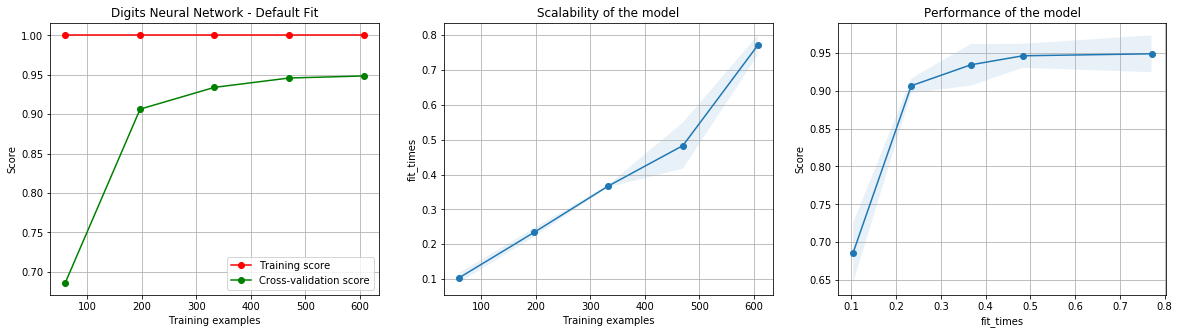

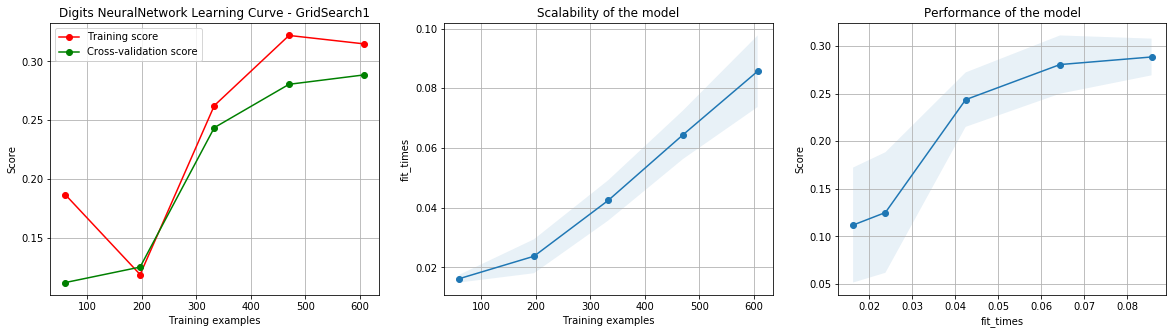

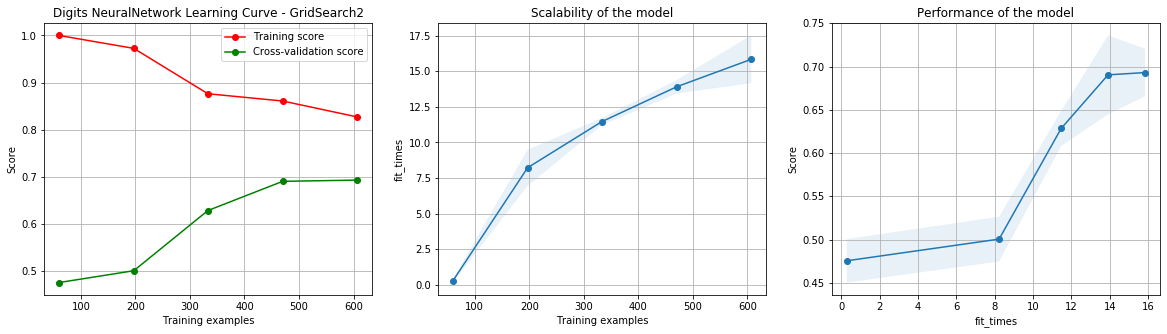

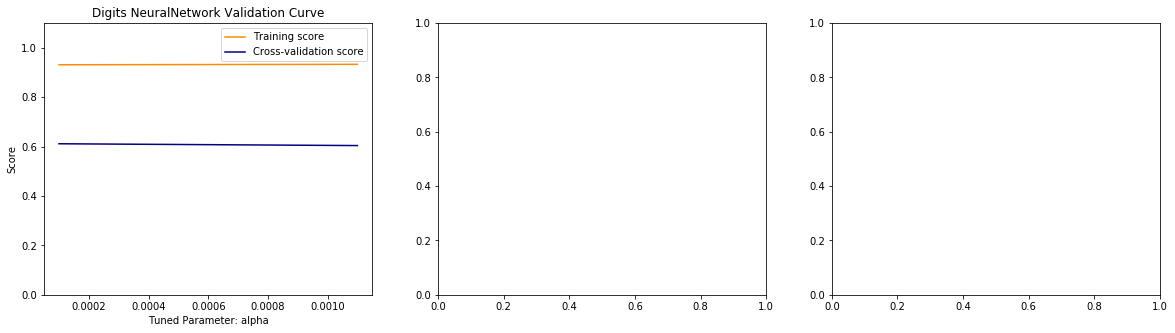

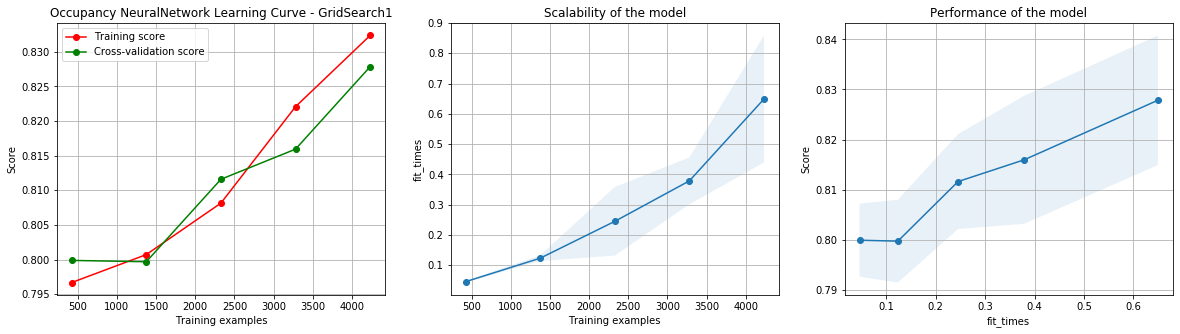

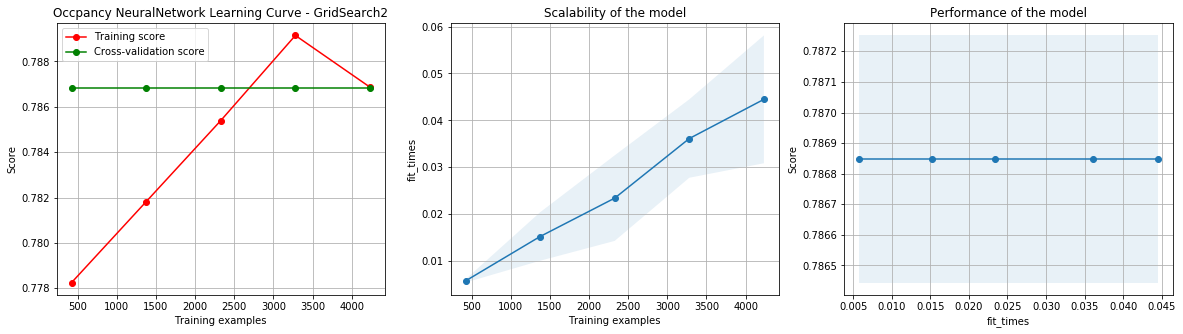

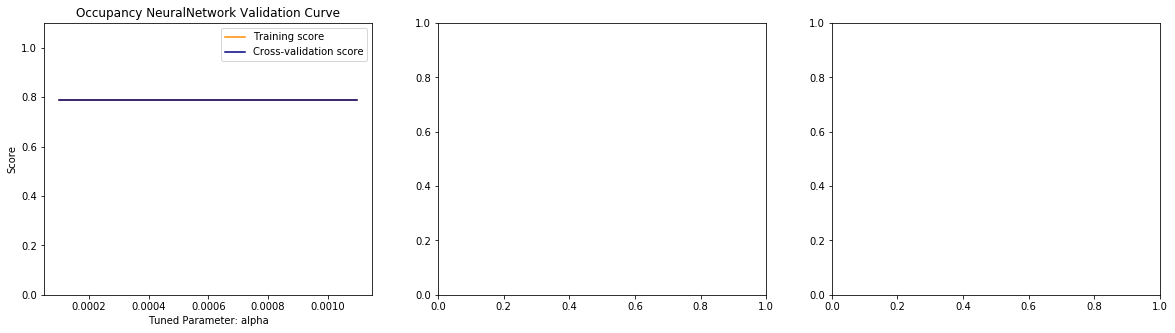

In [273]:
# Neural Networks

nn = MLPClassifier()
nn.fit(trainDigitX, trainDigitY)

plot_learning_curve(nn, "Digits Neural Network - Default Fit", trainDigitX, trainDigitY)

# Create Parameter Dict for GridSearch

params = {
    'activation': ['identity', 'tanh', 'relu', 'logistic'],
    'hidden_layer_sizes': [(2,10), (2, 50), (2, 100)],
    'early_stopping': [True],
    'max_iter': [10000],
    'random_state': [0]     
}

nn = MLPClassifier()
clf = GridSearchCV(nn, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)
best_nn = clf.best_estimator_
print(best_nn)
plot_learning_curve(best_nn, "Digits NeuralNetwork Learning Curve - GridSearch1", trainDigitX, trainDigitY, n_jobs=2)

params = {
    'learning_rate': ['invscaling', 'adaptive', 'constant'],
    'solver': ['adam', 'lbfgs', 'sgd'],
}

clf = GridSearchCV(best_nn, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)
best_nn = clf.best_estimator_
print(best_nn)
plot_learning_curve(best_nn, "Digits NeuralNetwork Learning Curve - GridSearch2", trainDigitX, trainDigitY, n_jobs=3)


plot_validation_curve(best_nn, "Digits NeuralNetwork Validation Curve", validDigitX, validDigitY, "alpha", [.0001, .0011])

ypred = best_nn.predict(validDigitX)
print("Validation Accuracy: %f" % accuracy_score(ypred, validDigitY))
ypred = best_nn.predict(testDigitX)
print("Test Accuracy: %f" % accuracy_score(ypred, testDigitY))


#################
# Occupancy Data
#################

params = {
    'activation': ['identity', 'tanh', 'relu', 'logistic'],
    'hidden_layer_sizes': [(2,10), (2, 50), (2, 100)],
    'early_stopping': [True],
    'max_iter': [10000],
    'random_state': [0]     
}

nn = MLPClassifier()
clf = GridSearchCV(nn, param_grid=params, n_jobs=3)
clf.fit(occTrainX, occTrainY)
best_nn = clf.best_estimator_
print(best_nn)
plot_learning_curve(best_nn, "Occupancy NeuralNetwork Learning Curve - GridSearch1", occTrainX, occTrainY, n_jobs=3)

params = {
    'learning_rate': ['invscaling', 'adaptive', 'constant'],
    'solver': ['adam', 'lbfgs', 'sgd'],
}

clf = GridSearchCV(best_nn, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)
best_nn = clf.best_estimator_
print(best_nn)
plot_learning_curve(best_nn, "Occpancy NeuralNetwork Learning Curve - GridSearch2", occTrainX, occTrainY, n_jobs=2)


plot_validation_curve(best_nn, "Occupancy NeuralNetwork Validation Curve", occValidX, occValidY, "alpha", [.0001, .0011])

ypred = best_knn.predict(occValidX)
print("Score against Validation Set: %f" % accuracy_score(ypred, occValidY))
ypred = best_knn.predict(occTestX)
print("Score against Test Set: %f" % accuracy_score(ypred, occTestY))



AdaBoostClassifier(algorithm='SAMME',
                   base_estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                         class_weight=None,
                                                         criterion='entropy',
                                                         max_depth=None,
                                                         max_features=None,
                                                         max_leaf_nodes=None,
                                                         min_impurity_decrease=0.0,
                                                         min_impurity_split=None,
                                                         min_samples_leaf=0.05,
                                                         min_samples_split=0.05,
                                                         min_weight_fraction_leaf=0.0,
                                                         presort='deprecated',
                

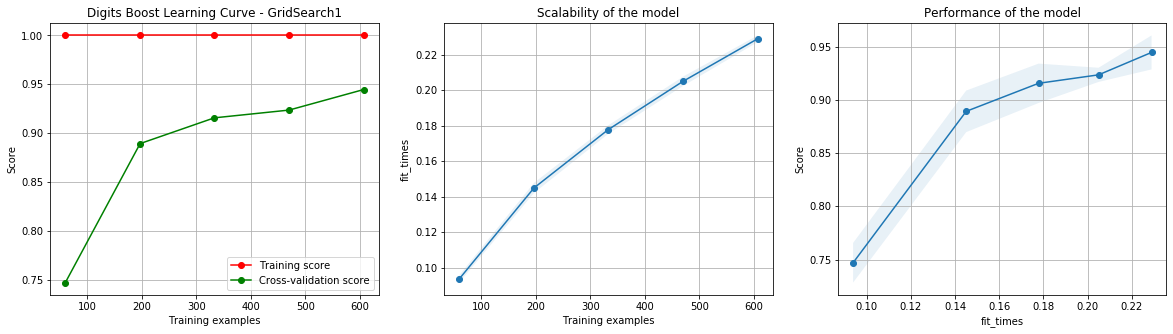

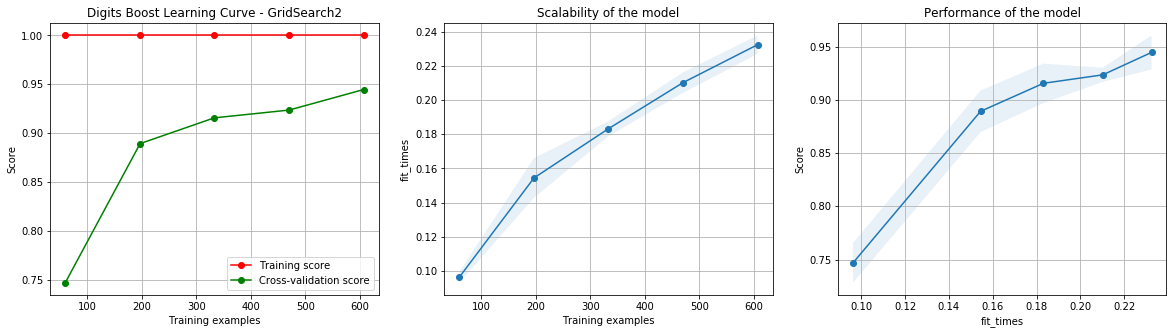

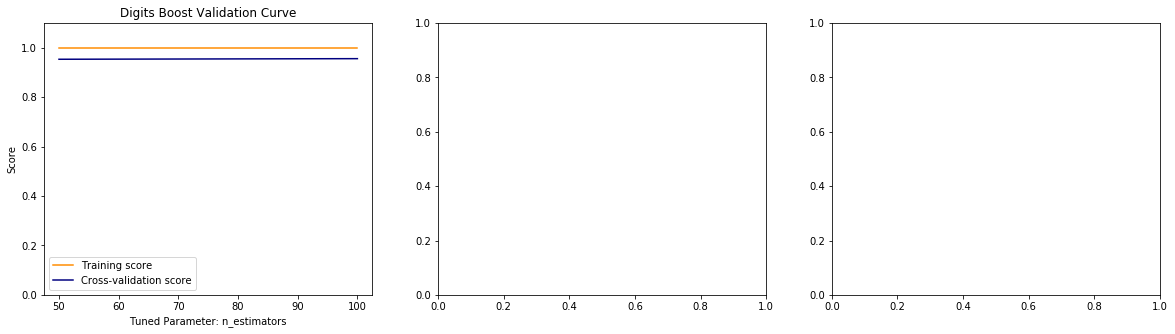

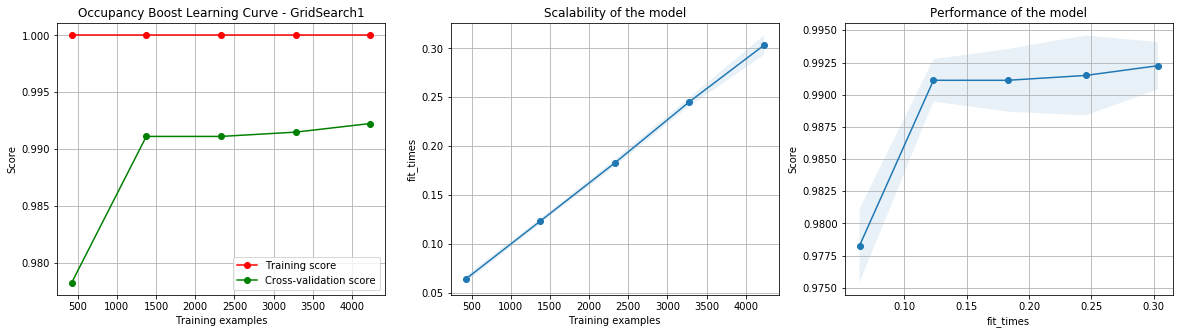

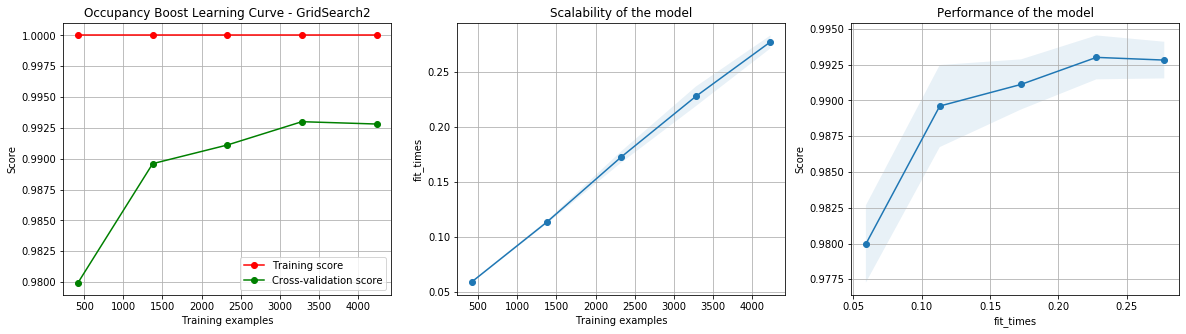

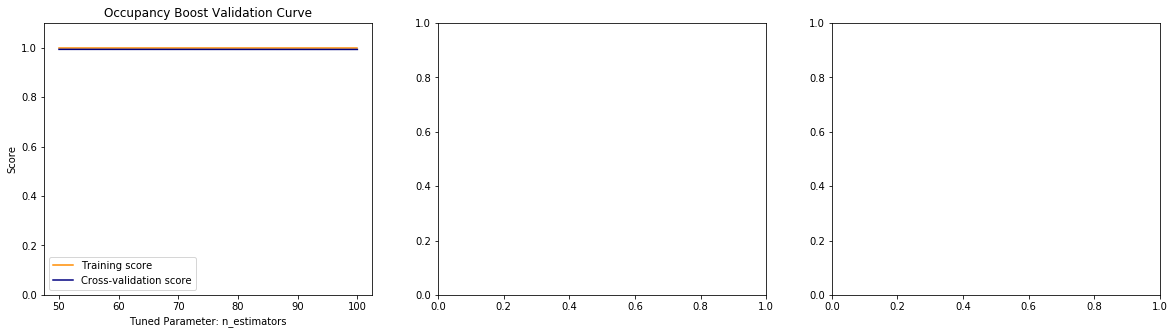

In [277]:
# Boosting

boost = AdaBoostClassifier(base_estimator=best_tree)

# Create Parameter Dictionary for GridSearchCV
params = {
    'random_state': [0],
    'algorithm': ['SAMME.R', 'SAMME']
}

clf = GridSearchCV(boost, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)

best_boost = clf.best_estimator_

plot_learning_curve(best_boost, "Digits Boost Learning Curve - GridSearch1", trainDigitX, trainDigitY, n_jobs=3)

params = {
    'learning_rate': [.2, .4, .6, .8, 1]
}

clf = GridSearchCV(best_boost, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)
best_boost = clf.best_estimator_
print(best_boost)
plot_learning_curve(best_boost, "Digits Boost Learning Curve - GridSearch2", trainDigitX, trainDigitY, n_jobs=3)

plot_validation_curve(best_boost, "Digits Boost Validation Curve", validDigitX, validDigitY, \
                      "n_estimators", [50, 100])

ypred = best_nn.predict(validDigitX)
print("Validation Accuracy: %f" % accuracy_score(ypred, validDigitY))
ypred = best_nn.predict(testDigitX)
print("Test Accuracy: %f" % accuracy_score(ypred, testDigitY))


# #################
# # Occupancy Data
# #################

boost = AdaBoostClassifier(base_estimator=occTree)

params = {
    'algorithm': ['SAMME.R', 'SAMME'],
    'random_state': [0]
}

clf = GridSearchCV(boost, param_grid=params, n_jobs=3)
clf.fit(occTrainX, occTrainY)

occBoost = clf.best_estimator_

plot_learning_curve(occBoost, "Occupancy Boost Learning Curve - GridSearch1", occTrainX, occTrainY, n_jobs=3)

params = {
    'learning_rate': [.2, .4, .6, .8, 1]
}

clf = GridSearchCV(occBoost, param_grid=params, n_jobs=3)
clf.fit(occTrainX, occTrainY)

occBoost = clf.best_estimator_
print(occBoost)

plot_learning_curve(occBoost, "Occupancy Boost Learning Curve - GridSearch2", occTrainX, occTrainY, n_jobs=3)

plot_validation_curve(occBoost, "Occupancy Boost Validation Curve", occValidX, occValidY, \
                      "n_estimators", [50, 100])

ypred = best_knn.predict(occValidX)
print("Score against Validation Set: %f" % accuracy_score(ypred, occValidY))
ypred = best_knn.predict(occTestX)
print("Score against Test Set: %f" % accuracy_score(ypred, occTestY))



Validation Accuracy: 0.286064
Test Accuracy: 0.281399
Score against Validation Set: 0.992283
Score against Test Set: 0.740338


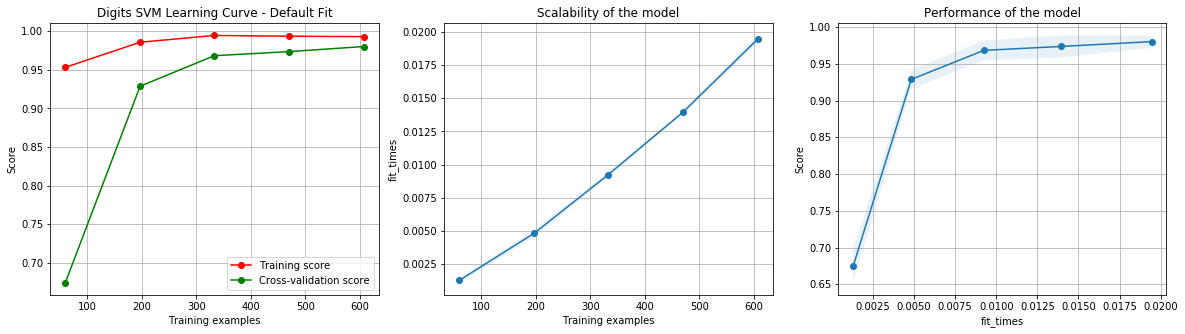

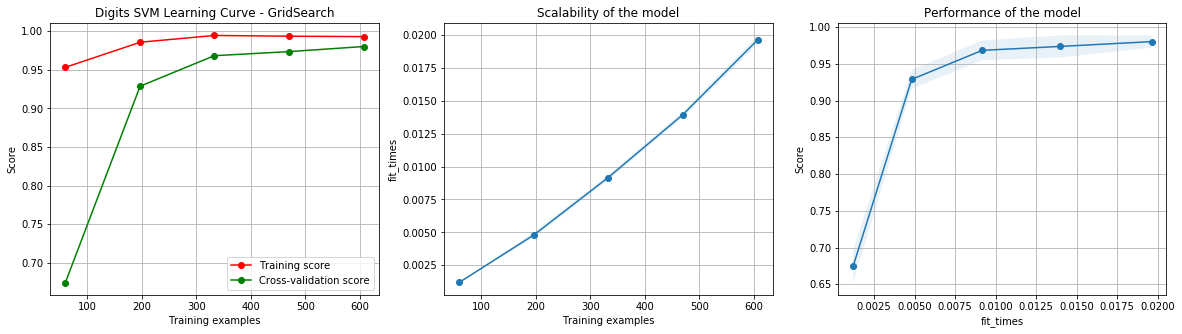

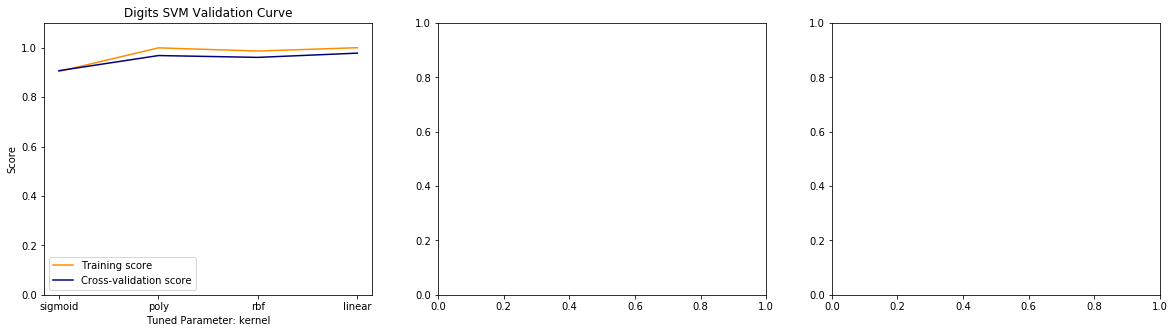

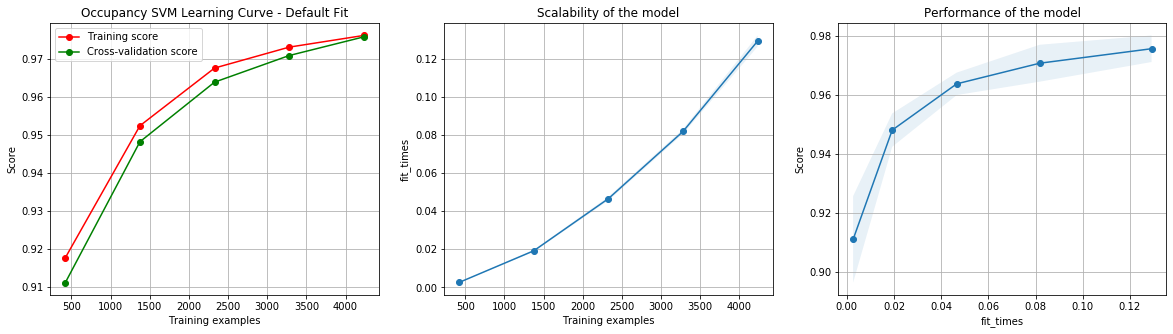

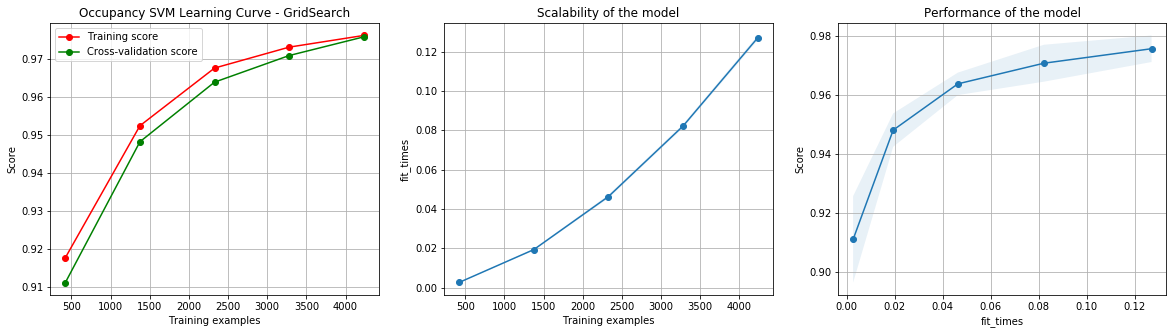

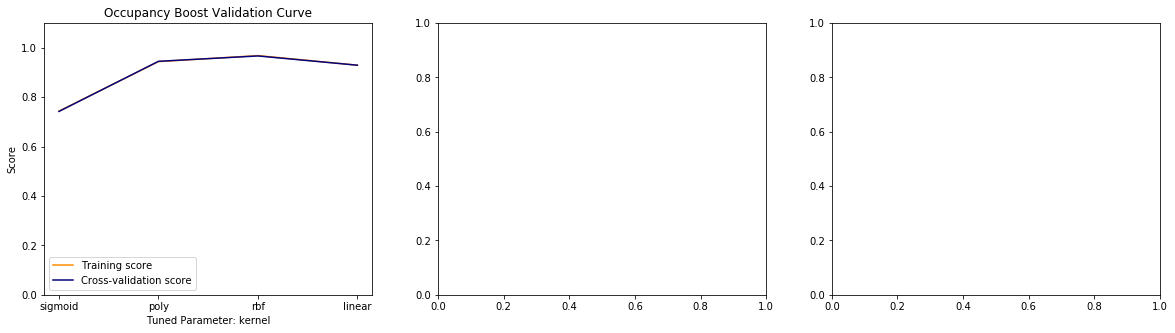

In [280]:
# Support Vector Machines

svc = SVC()
svc.fit(trainDigitX, trainDigitY)
plot_learning_curve(svc, "Digits SVM Learning Curve - Default Fit", trainDigitX, trainDigitY, n_jobs=3)


params = {
    'gamma': ['scale', 'auto']
}

svc = SVC()

clf = GridSearchCV(svc, param_grid=params, n_jobs=3)
clf.fit(trainDigitX, trainDigitY)

best_clf = clf.best_estimator_

plot_learning_curve(best_clf, "Digits SVM Learning Curve - GridSearch", trainDigitX, trainDigitY, n_jobs=3)

plot_validation_curve(best_clf, "Digits SVM Validation Curve", validDigitX, validDigitY, \
                      "kernel", ['sigmoid', 'poly', 'rbf', 'linear'])

best_clf.set_params(kernel='poly')

ypred = best_nn.predict(validDigitX)
print("Validation Accuracy: %f" % accuracy_score(ypred, validDigitY))
ypred = best_nn.predict(testDigitX)
print("Test Accuracy: %f" % accuracy_score(ypred, testDigitY))




# #################
# # Occupancy Data
# #################

svc = SVC()

svc.fit(occTrainX, occTrainY)
plot_learning_curve(svc, "Occupancy SVM Learning Curve - Default Fit", occTrainX, occTrainY, n_jobs=3)

params = {
    'gamma': ['scale', 'auto']
}

clf = GridSearchCV(svc, param_grid=params)
clf.fit(occTrainX, occTrainY)

best_clf = clf.best_estimator_

plot_learning_curve(best_clf, "Occupancy SVM Learning Curve - GridSearch", occTrainX, occTrainY, n_jobs=3)

plot_validation_curve(best_clf, "Occupancy Boost Validation Curve", occValidX, occValidY, \
                      "kernel", ['sigmoid', 'poly', 'rbf', 'linear'])

best_clf.set_params(kernel='rbf')

ypred = best_knn.predict(occValidX)
print("Score against Validation Set: %f" % accuracy_score(ypred, occValidY))
ypred = best_knn.predict(occTestX)
print("Score against Test Set: %f" % accuracy_score(ypred, occTestY))

